## CNN을 사용한 Fashon MNIST 이미지 분류  
#### 201921064 최요한  
(커널은 Python 3.10.13을 사용했습니다.)

In [21]:
import torch # torch, torch.optim, torch.nn.functional 모듈을 임포트하는데 PyTorch에서 모델을 구성하고 최적화하는 데 필요한 함수와 클래스를 제공
from torch import optim
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
import matplotlib.pyplot as plt
from pytorchcv import load_mnist, plot_results
load_mnist(batch_size=100)      #데이터가 균일하게 나눠질 수 있도록 배치사이즈를 100으로 설정

100.0%


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100.0%


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100.0%

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



## Fashoin MNIST 데이터 탐색  

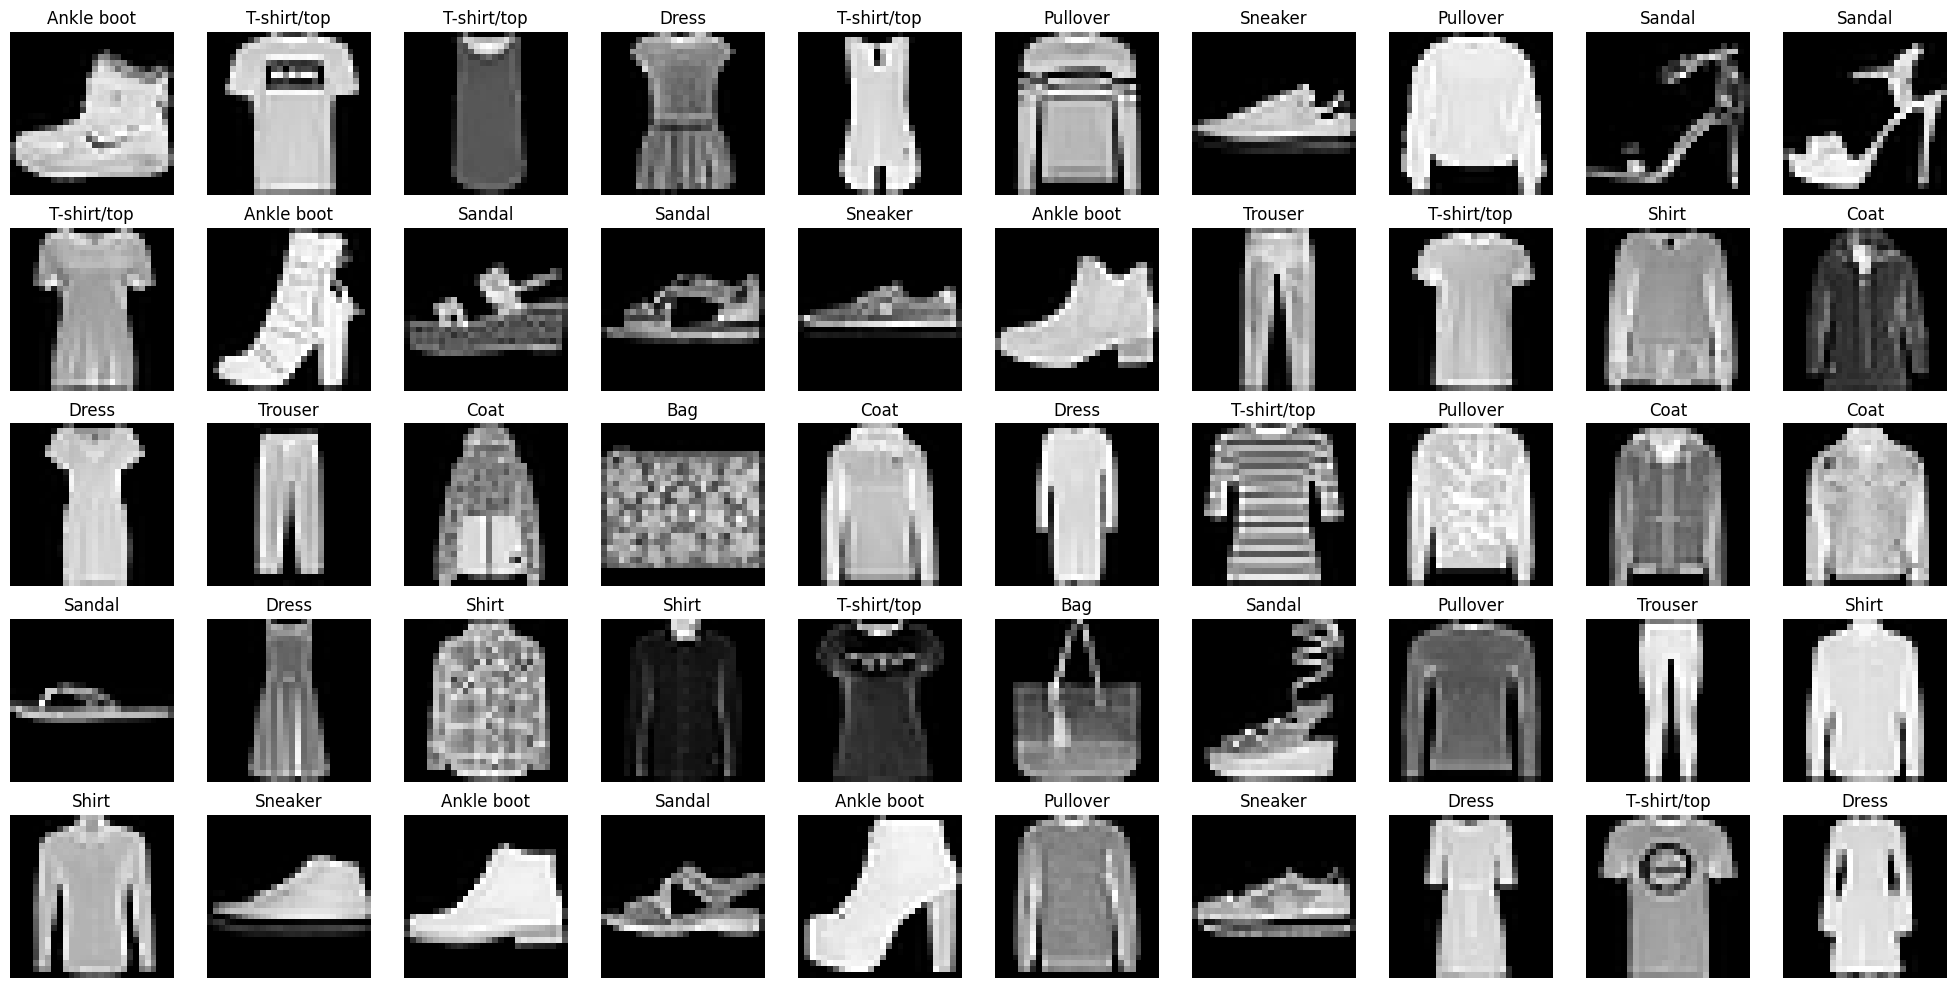

In [22]:
# FMNIST 데이터셋 불러오기
fmnist_train = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True)
fmnist_test = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True)
# load_mnist에서 불러온 데이터는 텐서가 되었기 때문에 새로 불러와줌


# 각 클래스들을 알아보기 쉽게 하기 위해 클래스 레이블 정의
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# 데이터 시각화
plt.figure(figsize=(25, 25))
for i in range(50):
    plt.subplot(10, 10, i + 1)
    plt.imshow(fmnist_train[i][0], cmap='gray')
    plt.title(classes[fmnist_train[i][1]])
    plt.axis('off')
plt.show()


Fashion MNIST 데이터는 위와 같이 티셔츠/탑, 바지, 풀오버(스웨터의 일종), 드레스, 코트, 샌들, 셔츠, 스니커즈, 가방, 앵클 부츠의 데이터가 있습니다.

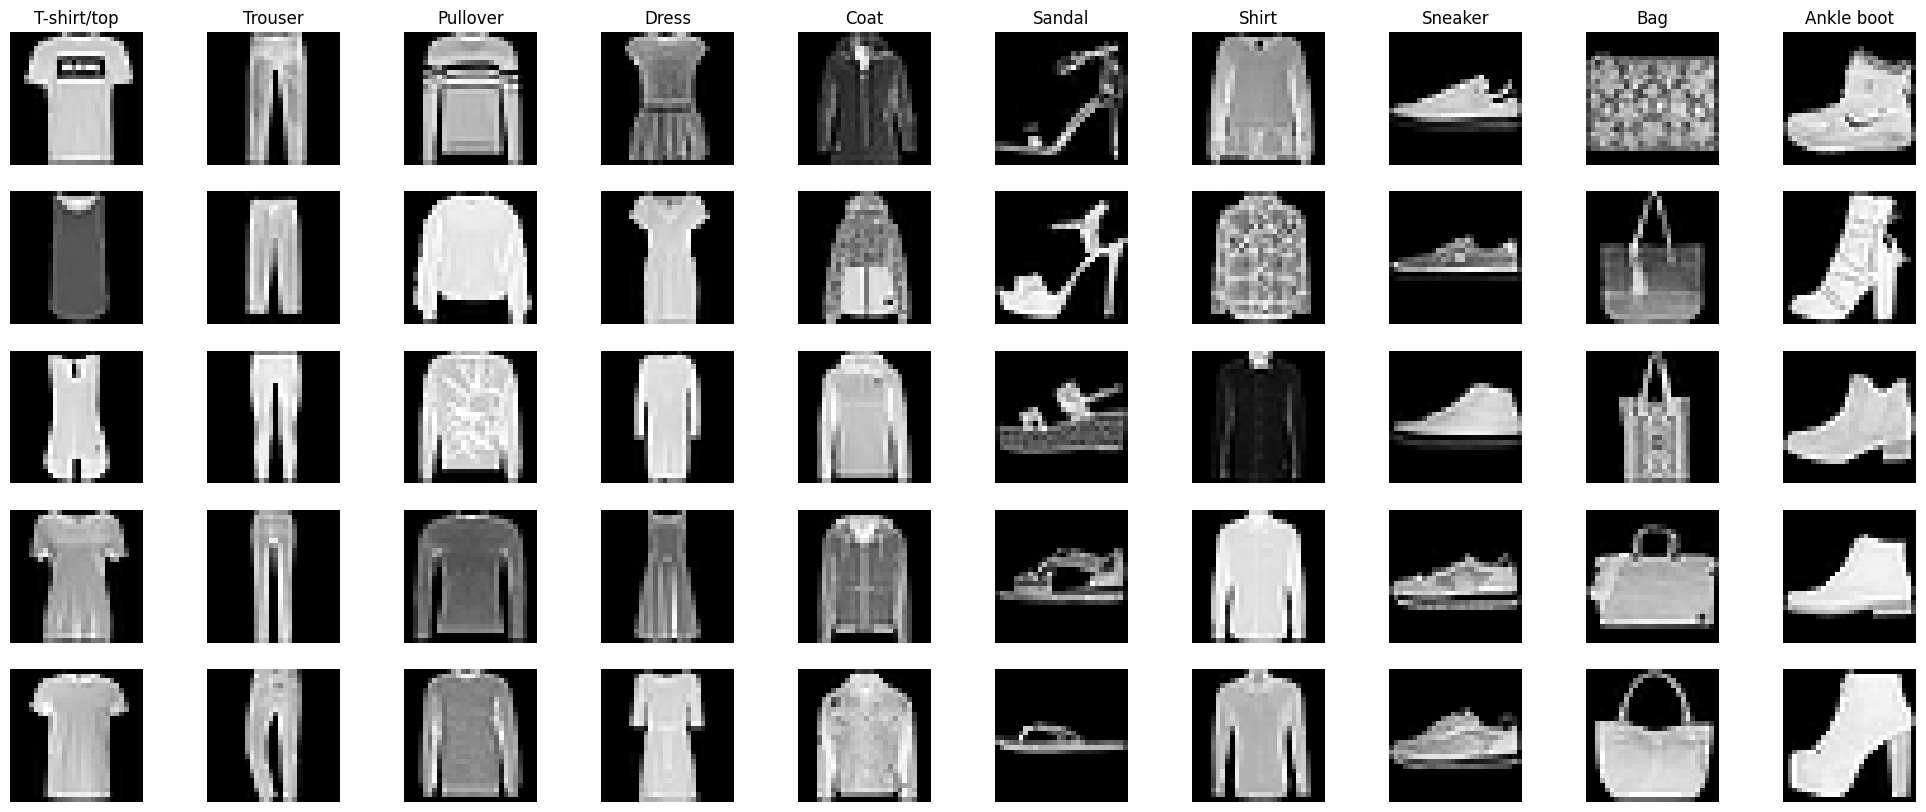

In [23]:
# 그래프를 그리기 위한 데이터 초기화
num_rows = 5
num_cols = 10
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 10)) #5행 10열로 적절히 나타냄

# 각 클래스별로 데이터 그리기
for class_idx in range(len(classes)):
    class_images = [image for image, label in fmnist_train if label == class_idx]
    for i in range(min(num_rows, len(class_images))):
        axes[i, class_idx].imshow(class_images[i], cmap='gray')
        axes[i, class_idx].axis('off')
        if i == 0:
            axes[i, class_idx].set_title(classes[class_idx])


plt.show()


클래스별로 어떤 데이터들이 있는지 나타내보았습니다.

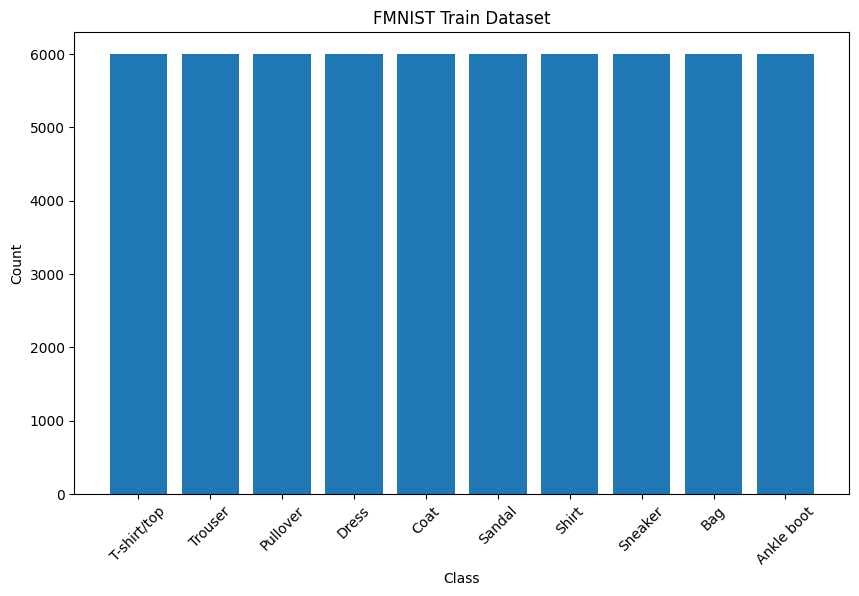

In [24]:
# 클래스별 데이터 수 확인
class_counts = [0] * len(classes)
for _, label in fmnist_train:
    class_counts[label] += 1 #일일이 직접 카운팅

# 시각화
plt.figure(figsize=(10, 6))
plt.bar(classes, class_counts) #클래스와 각 클래스가 몇개씩 있는지
plt.xlabel('Class') #x축 label
plt.ylabel('Count') #y축 label 
plt.title('FMNIST Train Dataset') 
plt.xticks(rotation=45) #글자가 겹치지 않게 45도 회전
plt.show()


  훈련용 데이터는 위와 같이 각 클래스의 데이터가 6000개씩 있습니다. 모두 10 클래스이므로  
훈련용 데이터는 총 6만개 있습니다.

In [25]:
# 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의하고, 그 구조를 요약해서 출력하는 과정을 설명
import torch.nn as nn # 파이토치의 신경망 모듈(nn)을 임포트
from torchsummary import summary # 설치된 torchsummary에서 summary 함수를 임포트


class OneConv(nn.Module): # nn.Module을 상속받는 OneConv라는 새로운 클래스를 정의하는데 nn.Module은 파이토치에서 모든 신경망 모듈의 기본 클래스

    def __init__(self): # 클래스의 생성자로, OneConv 객체가 생성될 때 초기화 과정을 정의
        super(OneConv, self).__init__()# 상위 클래스인 nn.Module의 생성자를 호출하여 클래스를 적절히 초기화
        # L1 입력 이미지=(?, 28, 28, 1)
        #    Conv     -> (?, 28, 28, 32)
        #    Pool     -> (?, 14, 14, 32)
        self.layer1 = nn.Sequential(   # 매개변수의 개수는 1*32*3*3 + 32 = 320
            nn.Conv2d(1, 32, kernel_size=(3,3), stride=(1,1), padding=1), #합성곱 계층
            nn.ReLU(), #활성 함수로 Relu 사용
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) #맥스 풀링
        # L2 입력 이미지 =(?, 14, 14, 32)
        #    Conv      ->(?, 14, 14, 64)
        #    Pool      ->(?, 7, 7, 64)
        self.layer2 = nn.Sequential(   # 매개변수의 개수는 32*64*3*3 + 64 = 18496
            nn.Conv2d(32, 64, kernel_size=(3,3), stride=(1,1), padding=1), #합성곱 계층
            nn.ReLU(), #활성 함수로 Relu 사용
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))) #맥스 풀링
        # L3 입력 이미지=(?, 7, 7, 64)
        #    Conv      ->(?, 7, 7, 128)
        #    Pool      ->(?, 4, 4, 128)
        self.layer3 = nn.Sequential(   # 매개변수의 개수는 64*128*3*3 + 128 = 73856
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=1), #합성곱 계층
            nn.ReLU(), #활성 함수로 Relu 사용
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2), padding=1)) #맥스 풀링

        # L4 FC 4x4x128 -> 625
        self.fc1 = nn.Linear(4*4*128, 625, bias=True)
        nn.init.xavier_uniform_(self.fc1.weight)
        
        self.layer4 = nn.Sequential(
            self.fc1,
            nn.ReLU(), #활성 함수로 Relu 사용
            nn.Dropout(0.5)) # overfitting 방지를 위해 dropout, 이후에 fc layer 존재
        
        # L5 Final FC 625 -> 10 
        self.fc2 = nn.Linear(625, 10, bias=True)
        nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x): # 모델의 순전파를 정의하는 메서드로 입력 텐서 x가 모델을 통과하는 과정을 설명
        if x.dim() == 5 and x.size(2) == 1:  # 입력 x의 차원이 예상치 못한 추가 차원을 포함하는 경우, 해당 차원을 제거
            x = x.squeeze(2)
        out = self.layer1(x) # 매개변수의 개수는 32*3*3 + 32 = 320
        out = self.layer2(out) # 매개변수의 개수는 32*64*3*3 + 64 = 18496
        out = self.layer3(out) # 매개변수의 개수는 64*128*3*3 + 128 = 73856
        out = out.view(out.size(0), -1)   # fc 계층을 위한 평탄화
        out = self.layer4(out)
        out = self.fc2(out)
        return out


# Create an instance of the network
net = OneConv() # OneConv 클래스의 인스턴스를 생성

# Print the summary of the model
summary(net,input_size=(1,1,28,28)) # 생성된 모델 net의 요약 정보를 출력하는데 여기서 input_size는 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비) 형식으로 지정

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          73,856
              ReLU-8            [-1, 128, 7, 7]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                  [-1, 625]       1,280,625
           Linear-11                  [-1, 625]       1,280,625
             ReLU-12                  [-1, 625]               0
          Dropout-13                  [-1, 625]               0
           Linear-14                   

Epoch 1/4: Train Loss: 0.0050, Train Acc: 81.63%, Test Loss: 0.0035, Test Acc: 86.95%
Epoch 2/4: Train Loss: 0.0031, Train Acc: 88.72%, Test Loss: 0.0029, Test Acc: 89.38%
Epoch 3/4: Train Loss: 0.0026, Train Acc: 90.55%, Test Loss: 0.0027, Test Acc: 90.31%
Epoch 4/4: Train Loss: 0.0023, Train Acc: 91.69%, Test Loss: 0.0027, Test Acc: 90.38%


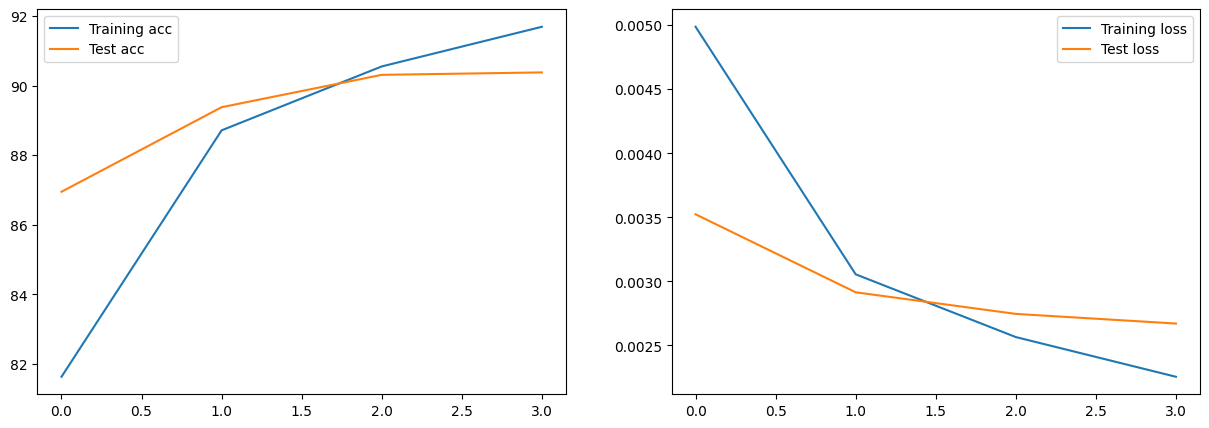

In [26]:
# 신경망 모델 net을 학습시키고 그 결과를 처리하는 과정을 보여줌

# train 함수를 호출하여 신경망 모델 net을 학습시키는데 학습 데이터 로더 train_loader, 테스트 데이터 로더 test_loader를 사용하고, 총 5 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 hist 변수에 저장
hist = train(net, train_loader, test_loader, epochs=4)

if hist is None: # train 함수에서 반환된 hist가 None인지 확인하는데 None은 학습 과정에서 오류가 발생했거나 예외가 처리되었음을 의미할 수 있음
    print("Training did not return any history.") # 만약 hist가 None이면, "학습이 어떠한 기록도 반환하지 않았습니다."라는 메시지를 출력하는데 이는 학습 과정에서 문제가 발생했음을 사용자에게 알리는 역할

else: # 만약 hist가 None이 아니라 유효한 데이터가 있으면
    plot_results(hist) # plot_results 함수를 호출하여 hist에 저장된 학습 결과(손실과 정확도 등)를 시각화하는데 이 함수는 일반적으로 matplotlib 같은 라이브러리를 사용하여 그래프를 그리고, 모델의 학습 진행 상황을 보여줌

epochs이 5일 경우 오히려 학습률이 감소하는 경우가 많아 4로 진행하였습니다.
성공적으로 학습이 진행된 모습입니다.

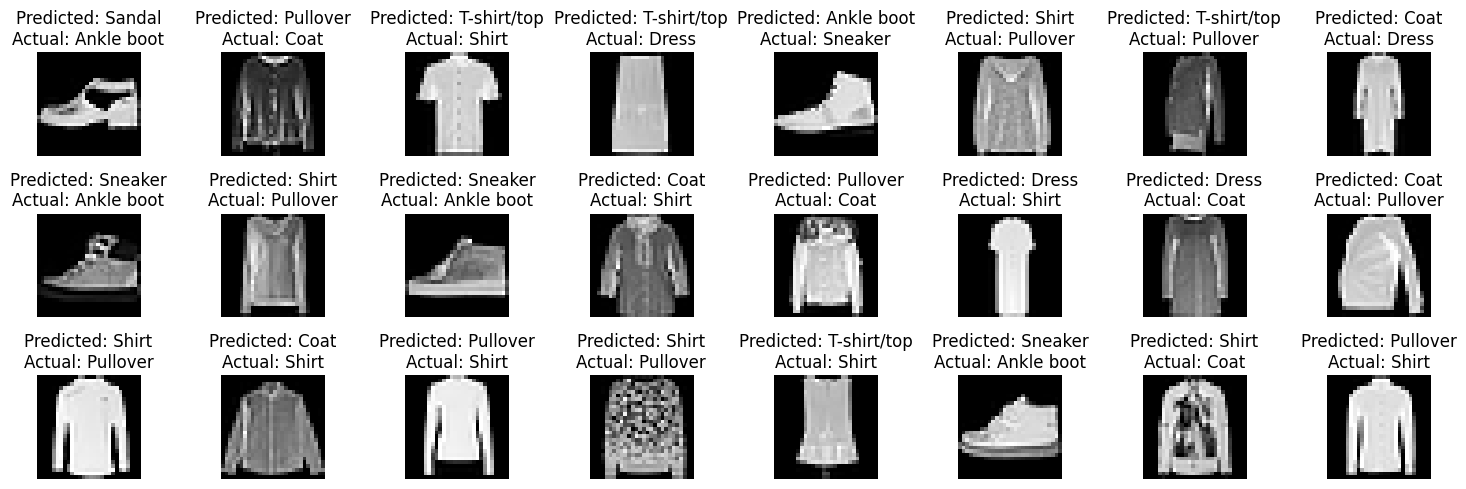

In [27]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transform)



# 모델을 평가모드로 설정
net.eval()

# 잘못 분류된 이미지들을 출력
wrong_predictions = []
correct_labels = []
predicted_labels = []

class_error_counts = [0] * len(classes)  # 잘못 분류된 이미지의 개수

with torch.no_grad():
    for images, labels in test_loader:
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        for i in range(len(predicted)):
            if predicted[i] != labels[i]:
                wrong_predictions.append(images[i])
                correct_labels.append(labels[i])
                predicted_labels.append(predicted[i])
                class_error_counts[labels[i]] += 1

# 잘못 분류된 이미지들을 어떻게 예측했지만 실제로는 무슨 값인지 출력
fig, axes = plt.subplots(3, 8, figsize=(15, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(wrong_predictions[i].squeeze(), cmap='gray')
    ax.set_title(f"Predicted: {classes[predicted_labels[i]]}\nActual: {classes[correct_labels[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()



잘못 분류된 이미지들입니다.

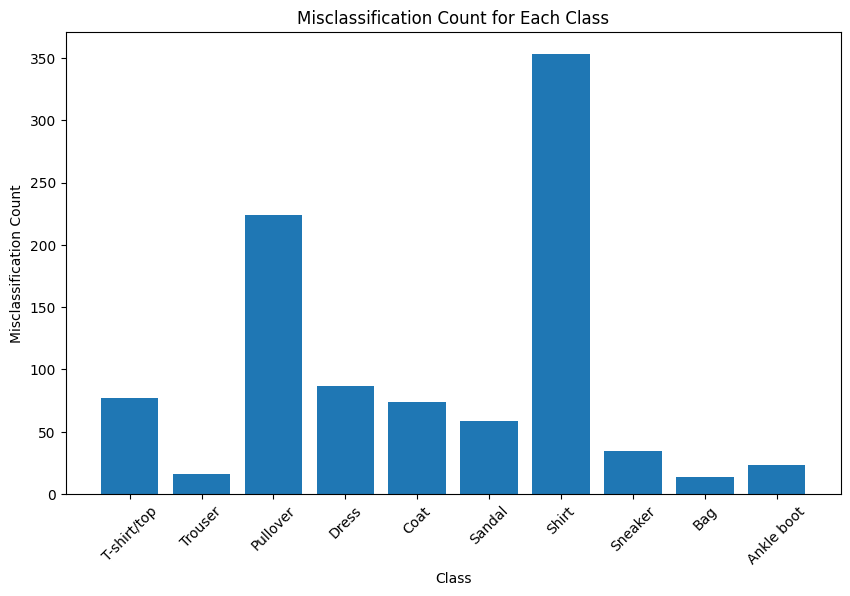

In [28]:

# 각 클래스 별로 잘못 분류된 이미지들을 출력
plt.figure(figsize=(10, 6))
plt.bar(classes, class_error_counts)
plt.xlabel('Class')
plt.ylabel('Misclassification Count')
plt.title('Misclassification Count for Each Class')
plt.xticks(rotation=45)
plt.show()

셔츠와 풀오버가 가장 많이 잘못 분류되었습니다.
